In [3]:
import os
import warnings
from datetime import datetime, timedelta
from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from prometheus_api_client import MetricSnapshotDataFrame, MetricRangeDataFrame, PrometheusConnect
from prometheus_api_client.utils import parse_datetime
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5


warnings.filterwarnings('ignore')


load_dotenv()

True

In [31]:
class BtalertIA:
    def __init__(self, last_minutes_importance: int, regressor=None) -> None:
        """
        Args:
            last_minutes_importance (int): The last minutes that matter to foreacasting (context)
        """
        self.prom = PrometheusConnect(
            url=os.getenv('PROMETHEUS_URL'), disable_ssl=True)
        self.regressor = regressor
        if regressor is None:
            self.regressor = RandomForestRegressor(
                max_depth=40,
                n_estimators=3,
                random_state=123,
            )
        self.forecaster = ForecasterAutoreg(
            regressor=self.regressor,
            lags=self.minutes_to_step(last_minutes_importance)
        )
        self.original_dataframe = pd.DataFrame()
        self.data_train = pd.DataFrame()
        self.data_test = pd.DataFrame()
        self.predictions = pd.Series()
        self.value_column = 'value'
        self.timestamp_column = 'timestamp'

    def load_metric_as_dataframe(self, start: str, end: str, metric_name: str, alias: str) -> pd.DataFrame:
        start_time = parse_datetime(start)
        end_time = parse_datetime(end)
        original_dataframe = MetricRangeDataFrame(
            self.prom.custom_query_range(
                query=metric_name, start_time=start_time, end_time=end_time, step=15)
        )[['value']]

        #new_dataframe = original_dataframe[[
        #    self.timestamp_column, self.value_column]].copy()
        #new_dataframe[self.timestamp_column] = [datetime.fromtimestamp(
        #    timestamp) for timestamp in new_dataframe[self.timestamp_column]]
        original_dataframe[self.value_column] = [
            float(value) for value in original_dataframe[self.value_column]]
        
        original_dataframe.rename(columns={'value': alias}, inplace=True)

        #original_dataframe.Index.astype('datetime64[s]')
        #new_dataframe[self.timestamp_column] = new_dataframe[self.timestamp_column].astype(
        #    'datetime64[s]')
        #new_dataframe = new_dataframe.set_index(
        #    new_dataframe[self.timestamp_column])

        #original_dataframe = original_dataframe.asfreq(freq='15S', method='bfill')
        self.original_dataframe = original_dataframe
        return original_dataframe

    def split_test_train_dataframe(self, minutes_split: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
        steps = self.minutes_to_step(minutes_split)

        self.data_train = self.original_dataframe[:-steps]
        self.data_test = self.original_dataframe[-steps:]

        return self.data_train, self.data_test

    def minutes_to_step(self, min: int) -> int:
        return int((min * 60) / 15)

    def train_model(self) -> None:
        self.forecaster.fit(y=self.data_train[self.value_column])

    def predict(self, minutes_prediction: int) -> pd.Series:
        self.predictions = self.forecaster.predict(steps=self.minutes_to_step(minutes_prediction))
        return self.predictions

    def plot_graphic(self):
        fig, ax = plt.subplots(figsize=(18, 12))
        self.data_train[self.value_column].plot(ax=ax, label='train')
        self.data_test[self.value_column].plot(ax=ax, label='test')
        self.predictions.plot(ax=ax, label='predictions')
        ax.legend()

    def get_mean_squared_error(self) -> float:
        error_mse: float = mean_squared_error(
            y_true=self.data_test[self.value_column],
            y_pred=self.predictions
        )
        return error_mse

    def execute(self, start: str, end: str, metric_name: str, minutes_split: int, minutes_prediction: int):
        self.load_metric_as_dataframe(start, end, metric_name)
        self.split_test_train_dataframe(minutes_split)
        self.train_model()
        self.predict(minutes_prediction)
# consts
start = '2022-05-11 07:50:07'
end = '2022-05-11 10:47:07'
#start = '2022-05-11 09:09:01'
#end = '2022-05-11 08:03:53'
min_split = 30
# teste
req_failed_ia = BtalertIA(60)

In [5]:
req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_failed_requests_percent')
req_failed_ia.split_test_train_dataframe(min_split)
req_failed_ia.train_model()
req_failed_ia.predict(30)
req_failed_ia.plot_graphic()

ValueError: negative dimensions are not allowed

In [32]:
req_failed = req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_failed_requests_percent', 'req_failed')
requests_per_second = req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_requests_per_second', 'request_per_sec')
#pg_lock_count = req_failed_ia.load_metric_as_dataframe(start, end, 'pg_lock_count')
max_cpu = req_failed_ia.load_metric_as_dataframe(start, end, 'max(rate(container_cpu_usage_seconds_total{image="api6-backend_cadastrol-server"}[1m:15s]))', 'cpu_percent')
memory = req_failed_ia.load_metric_as_dataframe(start, end, 'container_memory_rss{name="cadastrol-server"} / container_spec_memory_limit_bytes{name="cadastrol-server"}', 'memory_percent')

In [33]:
res = pd.concat([req_failed, requests_per_second, max_cpu, memory], axis=1)
res.head(10)

,req_failed,request_per_sec,cpu_percent,memory_percent
timestamp,,,,
1652266207,0.00,0.00,0.000286,0.681229
1652266222,0.00,0.80,0.022767,0.740280
1652266237,0.00,12.07,0.065587,0.783585
1652266252,0.00,15.27,0.116834,0.881149
1652266267,0.00,20.93,0.172781,0.863525
1652266282,0.00,30.07,0.192723,0.881653
1652266297,0.00,18.73,0.181848,0.883163
1652266312,10.00,2.00,0.121906,0.883667
1652266327,16.67,0.80,0.055520,0.891724


In [36]:
res.to_csv('dados.csv', sep=';', encoding='utf-8')

In [29]:
cor = res.corr()
cor

,req_failed,request_per_sec,cpu_percent,memory_percent
req_failed,1.000000,-0.648486,-0.497337,-0.504827
request_per_sec,-0.648486,1.000000,0.902064,0.367997
cpu_percent,-0.497337,0.902064,1.000000,0.340265
memory_percent,-0.504827,0.367997,0.340265,1.000000


<AxesSubplot:>

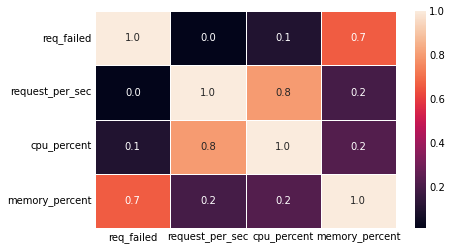

In [24]:
import seaborn as sn
plot = sn.heatmap(cor, annot=True, fmt='0.1f', linewidths=.6)
plot

<AxesSubplot:>

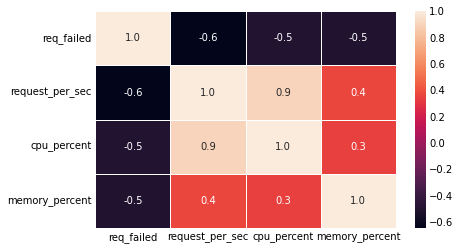

In [30]:
plot = sn.heatmap(cor, annot=True, fmt='0.1f', linewidths=.6)
plot